In [458]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_datareader as pdr # helps to pull the yahoo finance data
from sklearn.preprocessing import StandardScaler # helps to scale the data
from sklearn.preprocessing import RobustScaler # helps to scale the data
from sklearn import metrics # helps to evaluate the model
from sklearn.naive_bayes import GaussianNB # helps to build the model
from sklearn.linear_model import LogisticRegression # helps to build the model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix

from sklearn.ensemble import RandomForestClassifier
# roc and auc
# f score 
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [459]:
test = pd.read_csv('Data/test_titanic.csv')
train = pd.read_csv('Data/train_titanic.csv')
#test_y = pd.read_csv('Data/gender_submission.csv') # this is actually someone else's model
#del test_y['PassengerId']
#test=pd.concat([test_y,test],axis=1)
test.tail()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S
417,1309,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C


In [460]:
train.info()
# Missing data in age
# Sex needs to be converted to 1 or 0
#Missing cabin numbers - presumably did not have a cabin at all replace with none?
# 2 missing passengers in embarked

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [461]:
train['family']= train['SibSp'] + train['Parch']
test['family']= test['SibSp'] + test['Parch']
train['Alone'] = np.where(train['family']==0,1,0)
test['Alone'] = np.where(test['family']==0,1,0)
train['No_cabin'] = np.where(train['Cabin'].isna(),1,0)
test['No_cabin'] = np.where(test['Cabin'].isna(),1,0)
train['Gender'] = np.where(train['Sex']=="male",1,0)
test['Gender'] = np.where(test['Sex']=="male",1,0)
# filling gaps of age and fare with median
train[['Age', 'Fare']] = train[['Age', 'Fare']].fillna(train[['Age', 'Fare']].median())
test[['Age', 'Fare']] = test[['Age', 'Fare']].fillna(test[['Age', 'Fare']].median())
#test = test.dropna(axis=0, subset=['Age'])
#train = train.dropna(axis=0, subset=['Age'])

train.describe()
# Mean age of 30, median of 28 - likely little skew
# Mean fare of 32, median of 14 - indicates skew
#median number of siblings or spouses in 0, and mean is 50% could turn into a binary
#median number of parents/children is 0 and mean is 0.38
# median family member is 0 and mean is 0.9


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,family,Alone,No_cabin,Gender
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.361582,0.523008,0.381594,32.204208,0.904602,0.602694,0.771044,0.647587
std,257.353842,0.486592,0.836071,13.019697,1.102743,0.806057,49.693429,1.613459,0.489615,0.420397,0.477990
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400,0.000000,0.000000,1.000000,0.000000
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,0.000000,1.000000,1.000000,1.000000
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000,1.000000,1.000000,1.000000,1.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,10.000000,1.000000,1.000000,1.000000


In [462]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          418 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         418 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
 11  family       418 non-null    int64  
 12  Alone        418 non-null    int64  
 13  No_cabin     418 non-null    int64  
 14  Gender       418 non-null    int64  
dtypes: float64(2), int64(8), object(5)
memory usage: 49.1+ KB


/var/folders/w3/j_v3f_rs4hlbh_rnzsc6j2rm0000gn/T/ipykernel_75202/1559594214.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  train.corr()
/var/folders/w3/j_v3f_rs4hlbh_rnzsc6j2rm0000gn/T/ipykernel_75202/1559594214.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train.corr(),annot=True)


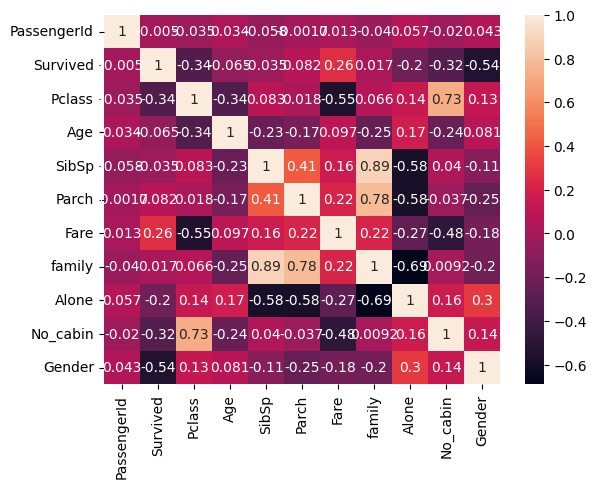

<Figure size 1000x500 with 0 Axes>

In [463]:
train.corr()

# could use seaborn heatmap to display this
sns.heatmap(train.corr(),annot=True)
plt.figure(figsize=(10,5))
plt.show()

In [464]:
# Gender has good correlation with survived, as does not having a cabin, tho no cabin is v correlated with class, and somewhat with fare
# Sibsp and Parch and family have v low correlations - but the alone variable has better coeff, therefore will drop them
# Age has poor correlation - maybe relationship is not linear so should be investigated

del train['SibSp']
del train['Parch']
del test['SibSp']
del test['Parch']
del test['family']
del train['family']
del train['PassengerId']
del test['PassengerId']
del train['Name']
del test['Name']

train['Age_Cat']=pd.cut(train.Age,bins=[0,2,17,65,99],labels=['Toddler/Baby','Child','Adult','Elderly'])
test['Age_Cat']=pd.cut(test.Age,bins=[0,2,17,65,99],labels=['Toddler/Baby','Child','Adult','Elderly'])



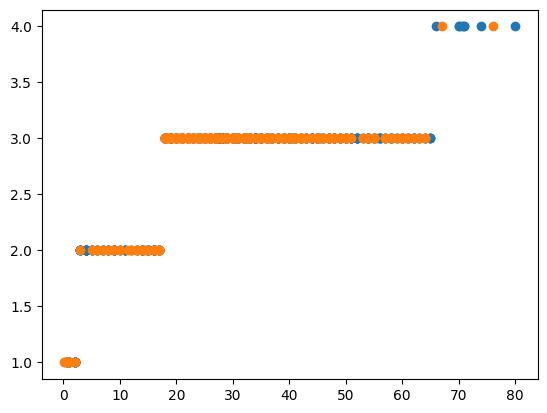

In [465]:
train['Age_Cat_num'] = train['Age_Cat'].replace(['Toddler/Baby','Child','Adult','Elderly'],
                        [1,2,3,4], inplace=False)

test['Age_Cat_num'] = test['Age_Cat'].replace(['Toddler/Baby','Child','Adult','Elderly'],
                        [1,2,3,4], inplace=False)
m
plt.scatter(train['Age'],train['Age_Cat_num'])
plt.scatter(test['Age'],test['Age_Cat_num'])

In [466]:
del train['Ticket']
del test['Ticket']
del train['Cabin']
del test['Cabin']
del train['Sex']
del test['Sex']
del train['Embarked']
del test['Embarked']
train.head()

,Survived,Pclass,Age,Fare,Alone,No_cabin,Gender,Age_Cat,Age_Cat_num
0,0,3,22.0,7.2500,0,1,1,Adult,3
1,1,1,38.0,71.2833,0,0,0,Adult,3
2,1,3,26.0,7.9250,1,1,0,Adult,3
3,1,1,35.0,53.1000,0,0,0,Adult,3
4,0,3,35.0,8.0500,1,1,1,Adult,3


In [467]:
train['Age_Cat_num']=pd.to_numeric(train['Age_Cat_num'])
test['Age_Cat_num']=pd.to_numeric(test['Age_Cat_num'])
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Survived     891 non-null    int64   
 1   Pclass       891 non-null    int64   
 2   Age          891 non-null    float64 
 3   Fare         891 non-null    float64 
 4   Alone        891 non-null    int64   
 5   No_cabin     891 non-null    int64   
 6   Gender       891 non-null    int64   
 7   Age_Cat      891 non-null    category
 8   Age_Cat_num  891 non-null    int64   
dtypes: category(1), float64(2), int64(6)
memory usage: 56.9 KB


/var/folders/w3/j_v3f_rs4hlbh_rnzsc6j2rm0000gn/T/ipykernel_75202/4231946867.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  train.corr()
/var/folders/w3/j_v3f_rs4hlbh_rnzsc6j2rm0000gn/T/ipykernel_75202/4231946867.py:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train.corr(),annot=True)


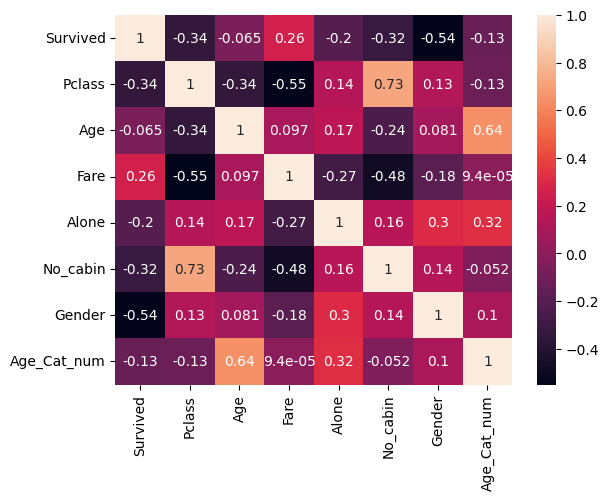

<Figure size 1000x500 with 0 Axes>

In [468]:
#train = pd.get_dummies(data=train[], drop_first=True)
#test = pd.get_dummies(data=test, drop_first=True)
train.corr()

# could use seaborn heatmap to display this
sns.heatmap(train.corr(),annot=True)
plt.figure(figsize=(10,5))
plt.show()

In [469]:
#Normalize variables between 0 & 1

#VariableList = ['Age','Fare','Pclass']
#normVariableName = ['Age_norm','Fare_norm','Pclass_norm']

#scaler = MinMaxScaler()

#for i in range(0,len(test)):
#    for j in range(0,len(VariableList)):
#        temp = test[VariableList[j]]
#        temp1 = temp.values.reshape(-1,1)
#        scaler.fit(temp1)
#        test.at[i,normVariableName[j]]=norm[i]
##        norm =scaler.transform(temp1)
#test


#for i in range(0,len(train)):
#    for j in range(0,len(VariableList)):
#        temp = train[VariableList[j]]
#        temp1 = temp.values.reshape(-1,1)
#        scaler.fit(temp1)
#        norm =scaler.transform(temp1)
#        train.at[i,normVariableName[j]]=norm[i]
#train


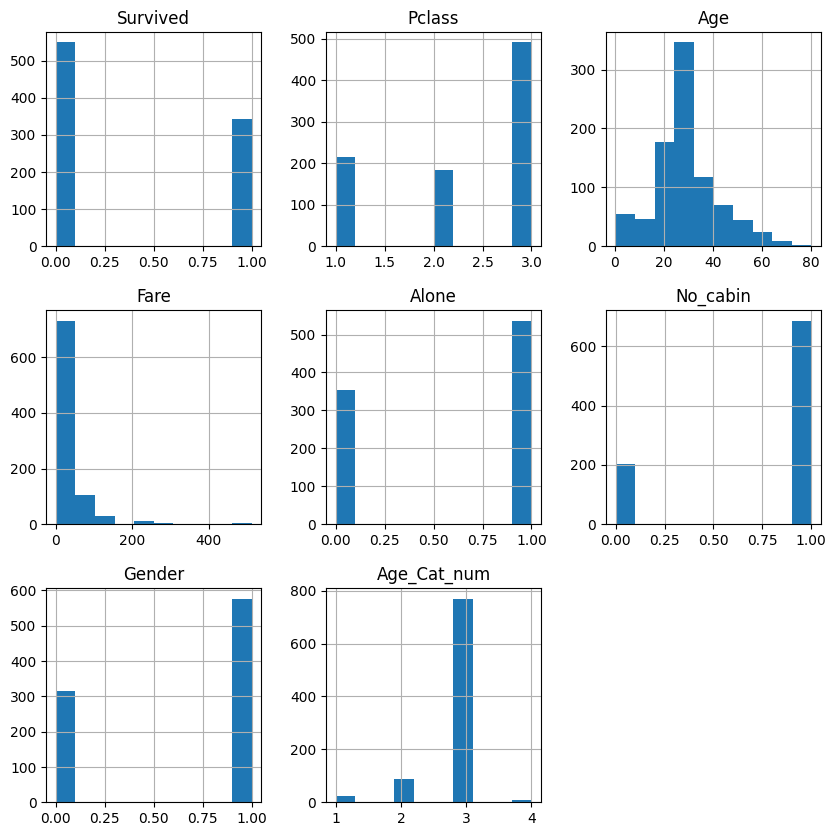

In [470]:
train.hist(bins=10, figsize=(10,10))
plt.show()
del train['Age_Cat']
del test['Age_Cat']
del train['Age']
del test['Age']

In [471]:

X_train = train.iloc[:,1:7].values # selection of variables based on previous analysis
Y_train = train.iloc[:, 0].values # survival is outcome

X_test = test.iloc[:,1:7].values # selection of variables based on previous analysis
#Y_test = test.iloc[:,0].values # removed this because this was actually someone else' dataset


scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train) # Scaling  training set
X_test = scaler_X.transform(X_test) # Scaling test set

logisticRegression_model = LogisticRegression(random_state=0) # Logistic Regression model
logisticRegression_model.fit(X_train, Y_train) # Training the model

prediction = logisticRegression_model.predict(X_test) # Predict the response

#c_matrix = confusion_matrix(Y_test, prediction) # Create a confusion matrix this is like a fals poseitive, false neg matrix
#print("Accuracy:", (confusion_matrix[0][0] + confusion_matrix[1][1]) / 22) # Checking LR accuracy
#Y_test

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3378, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/w3/j_v3f_rs4hlbh_rnzsc6j2rm0000gn/T/ipykernel_75202/2373053192.py", line 10, in <module>
    X_test = scaler_X.transform(X_test) # Scaling test set
             ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_data.py", line 975, in transform
    X = self._validate_data(
        ^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py", line 600, in _validate_data
    self._check_n_features(X, reset=reset)
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py", line 400, in _check_n_features
    raise ValueError(
ValueError: X has 

In [472]:
prediction

array([0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0])

In [473]:
pd.crosstab(train['Gender'], train['Survived'], normalize='index')


Survived,0,1
Gender,,
0,0.257962,0.742038
1,0.811092,0.188908


In [474]:
pd.crosstab(train['Age_Cat_num'], train['Survived'], normalize='index')

Survived,0,1
Age_Cat_num,,
1,0.375000,0.625000
2,0.483146,0.516854
3,0.636364,0.363636
4,0.875000,0.125000


In [475]:
pd.crosstab(train['No_cabin'], train['Survived'], normalize='index')

Survived,0,1
No_cabin,,
0,0.333333,0.666667
1,0.700146,0.299854


In [476]:
pd.crosstab(train['Pclass'], train['Survived'], normalize='index')

Survived,0,1
Pclass,,
1,0.370370,0.629630
2,0.527174,0.472826
3,0.757637,0.242363


In [477]:
pd.crosstab(train['Alone'], train['Survived'], normalize='index')

Survived,0,1
Alone,,
0,0.494350,0.505650
1,0.696462,0.303538


In [478]:
#prediction = pd.DataFrame(data=prediction, columns=['Survived'])
#test_prediction=pd.concat([prediction,test], axis=1)
#test_prediction.tail()

In [479]:
train.tail()

,Survived,Pclass,Fare,Alone,No_cabin,Gender,Age_Cat_num
886,0,2,13.00,1,1,1,3
887,1,1,30.00,1,0,0,3
888,0,3,23.45,0,1,0,3
889,1,1,30.00,1,0,1,3
890,0,3,7.75,1,1,1,3


In [480]:
# create dummy data and classifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
# key metrics 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error



In [481]:

## Running the models, and cutting up the 
X_train, X_test, Y_train, Y_test = train_test_split(train.iloc[:,1:7],train.iloc[:,0], test_size=0.3,random_state=0) # creates training and test sets

scaler_X = MinMaxScaler() # this is often a really good one to use, but the industry standard is the standard scaler
X_train = scaler_X.fit_transform(X_train) # Scaling  training set
X_test = scaler_X.transform(X_test) # Scaling test set

#scaler_X = MinMaxScaler()


logisticRegression_model = LogisticRegression(random_state=0) # Logistic Regression model
logisticRegression_model.fit(X_train, Y_train) # Training the model

prediction = logisticRegression_model.predict(X_test) # Predict the response

In [482]:
## CALCULATE ACCURACY
accuracy = accuracy_score(Y_test, prediction) 

print("Accuracy score for logistic regression is:",accuracy)

Accuracy score for logistic regression is: 0.7873134328358209


Confusion matrix for log regression


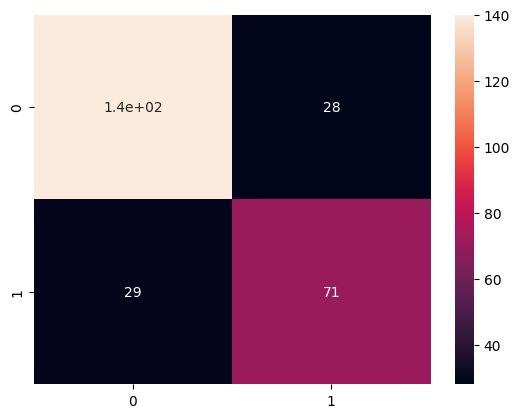

In [483]:
## CREATE CONFUSION MATRIX
print("Confusion matrix for log regression")
CM = confusion_matrix(Y_test , prediction)
sns.heatmap(pd.DataFrame(CM), annot=True)

TN, FP, FN, TP = CM.ravel() # students do not need to do this, but good for you to have if they ask

In [484]:
## CALCUATE PRECISION, RECALL AND SPECIFICITY
precision = TP/(TP+FP)
recall = TP/(TP+FN) 
specificity = TN/(TN+FP)

print("Precision for log regression is:",precision)
print("Recall/sensitivity for log regression is:",recall)
print("Specificity for log regression is:",specificity)

Precision for log regression is: 0.7171717171717171
Recall/sensitivity for log regression is: 0.71
Specificity for log regression is: 0.8333333333333334


In [485]:
# creating a merged dataset
full_data=pd.concat([train,test], axis=0)

import statsmodels.api as sm

#log_clf = LogisticRegression()

log_clf =sm.Logit(train.iloc[:,0],train.iloc[:,1:7])

classifier = log_clf.fit()

y_pred = classifier.predict(X_test)

print(classifier.summary2())

Optimization terminated successfully.
         Current function value: 0.488549
         Iterations 6
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.266     
Dependent Variable: Survived         AIC:              882.5935  
Date:               2022-11-14 14:22 BIC:              911.3475  
No. Observations:   891              Log-Likelihood:   -435.30   
Df Model:           5                LL-Null:          -593.33   
Df Residuals:       885              LLR p-value:      3.5211e-66
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     6.0000                                       
------------------------------------------------------------------
              Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
------------------------------------------------------------------
Pclass       -0.1794    0.1365   -1.3145  0.1887  -0.4469   0.0881
Fare          0.0074    0.0026    2.8719  0.0041   0.0023   0.

AUC for log regression is: 0.771667


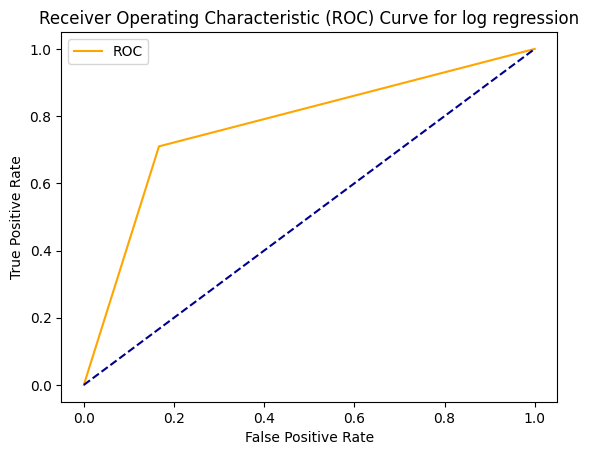

F Score: 0.713568


In [486]:

## CALCULATE AUC

auc = roc_auc_score(Y_test, prediction)
print('AUC for log regression is: %f' %auc)

## PLOT ROC CURVE

fpr, tpr,threshold = roc_curve(Y_test,prediction)

plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for log regression')
plt.legend()
plt.show()


## CALCULATE F SCORE 

fscore = f1_score(Y_test, prediction)
print('F Score: %f' %fscore)

In [487]:


## CREATE DECISION TREE

model = DecisionTreeClassifier(random_state=0) 
model.fit(X_train, Y_train)


## CREATE NEW PREDICTIONS

prediction = model.predict(X_test)

Accuracy for decision tree is: 0.832089552238806
Precision for decision tree: 0.8089887640449438
Recall/sensitivity for decision tree: 0.72
Specificity for decision tree: 0.8988095238095238


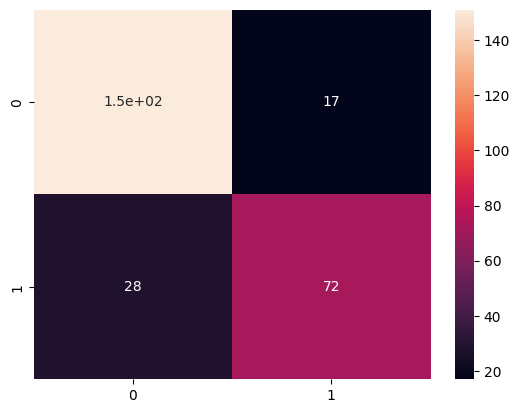

In [488]:
## CREATE CONFUSION MATRIX
CM = confusion_matrix(Y_test , prediction)
sns.heatmap(pd.DataFrame(CM), annot=True)

TN, FP, FN, TP = CM.ravel() # students do not need to do this, but good for you to have if they ask

## CALCULATE ACCURACY
accuracy = accuracy_score(Y_test , prediction)

print("Accuracy for decision tree is:",accuracy)

## CALCUATE PRECISION, RECALL AND SPECIFICITY
precision = TP/(TP+FP)
recall = TP/(TP+FN) 
specificity = TN/(TN+FP)

print("Precision for decision tree:",precision)
print("Recall/sensitivity for decision tree:",recall)
print("Specificity for decision tree:",specificity)



AUC for decision tree: 0.809405


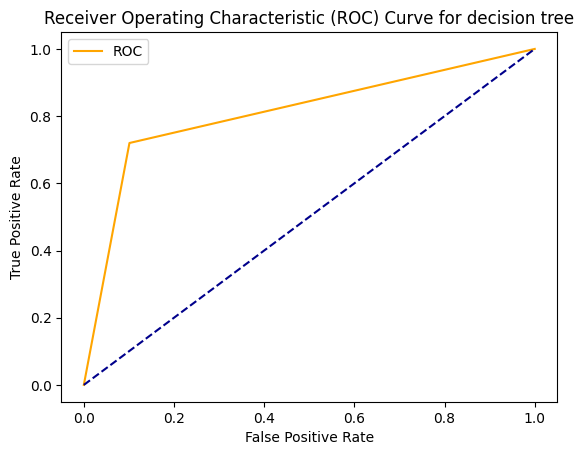

F Score for decision tree: 0.761905


In [489]:


## CALCULATE AUC

auc = roc_auc_score(Y_test, prediction)
print('AUC for decision tree: %f' %auc)

## PLOT ROC CURVE

fpr, tpr,threshold = roc_curve(Y_test,prediction)

plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for decision tree')
plt.legend()
plt.show()


## CALCULATE F SCORE 

fscore = f1_score(Y_test, prediction)
print('F Score for decision tree: %f' %fscore)

In [490]:
## CREATE random forest

rf = RandomForestClassifier(random_state=0) 
rf.fit(X_train, Y_train)


## CREATE NEW PREDICTIONS

prediction = rf.predict(X_test)

In [491]:
## CALCULATE ACCURACY
accuracy = accuracy_score(Y_test , prediction)

print(accuracy)

0.832089552238806


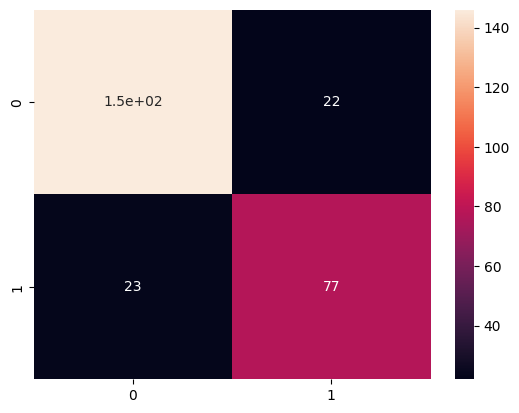

In [492]:
## CREATE CONFUSION MATRIX
CM = confusion_matrix(Y_test , prediction)
sns.heatmap(pd.DataFrame(CM), annot=True)

TN, FP, FN, TP = CM.ravel() # students do not need to do this, but good for you to have if they ask

In [493]:
## CALCUATE PRECISION, RECALL AND SPECIFICITY
precision = TP/(TP+FP)
recall = TP/(TP+FN) 
specificity = TN/(TN+FP)

print("Precision for random forest is:",precision)
print("Recall/sensitivity for random forest is:",recall)
print("Specificity for random forest is:",specificity)

Precision for random forest is: 0.7777777777777778
Recall/sensitivity for random forest is: 0.77
Specificity for random forest is: 0.8690476190476191


AUC for random forest: 0.819524


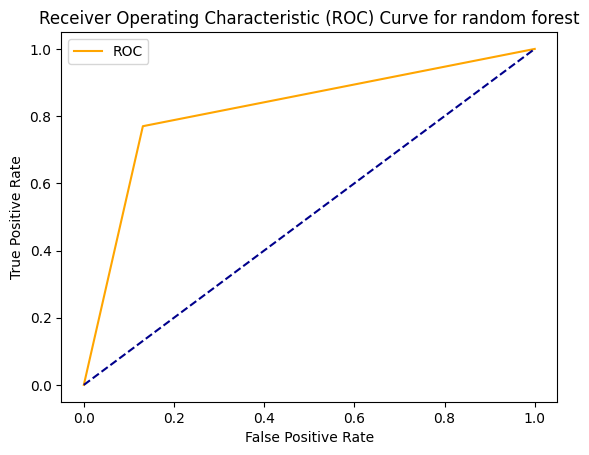

F Score for random forest: 0.773869


In [494]:

## CALCULATE AUC

auc = roc_auc_score(Y_test, prediction)
print('AUC for random forest: %f' %auc)

## PLOT ROC CURVE

fpr, tpr,threshold = roc_curve(Y_test,prediction)

plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for random forest')
plt.legend()
plt.show()


## CALCULATE F SCORE 

fscore = f1_score(Y_test, prediction)
print('F Score for random forest: %f' %fscore)